# Freeway

This is the project T-AIA-902.

In this project we propose to apply Reinforcement Learning methods to teach an agent how to play the Freeway Atari game.

## Freeway game

![Baseline 1](./img/Freeway_logo.png)

In the game, two players compete against each other trying to make their chickens cross the street, while evading the cars passing by.
There are three possible actions: staying still, moving forward or moving backward.
Each time a chicken collides with a car, it is forced back some spaces and takes a while until the chicken regains its control.

When a chicken is successfully guided across the freeway, it is awarded one point and moved to the initial space, where it will try to cross the street again.
The game offers multiple scenarios with different vehicles configurations (varying the type, frequency and speed of them) and plays for 2 minutes and 16 seconds.
During the 8 last seconds the scores will start blinking to indicate that the game is close to end.
Whoever has the most points after this, wins the game!

The image was extracted from the [manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf).

We will be using the [Gymnasium] toolkit.

You can find more information regarding the environment used at [Freeway-ram-v4].

# Setup

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex


# Imports

In [2]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [3]:
%matplotlib inline
import statistics
from collections import defaultdict
from functools import lru_cache
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym

from IPython.display import clear_output

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer
import src.gif as gif

In [4]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

# Action space

As we said above, the agent in this game has three possible actions at each frame, each represented by an integer:

* 0: Stay
* 1: Move forward

# Baseline

## Simple baseline agent

As a simple baseline, we are using an agent that always moves **up**, regardless of the rewards received or the current state.

In [5]:
env, initial_state = environment.get_env()

In [6]:
agent = agents.Baseline()

In [7]:
total_rewards = []
n_runs = 10

In [8]:
# %%time
# for i in range(n_runs):
#     render = i % 10 == 0

#     game_over = False
#     state = env.reset()
#     action = agent.act(state)

#     total_reward = 0

#     while not game_over:
#         if render:
#             time.sleep(0.01)
#             env.render()

#         ob, reward, game_over, _, _ = env.step(action)

#         total_reward += reward
#         action = agent.act(state)  # Next action

#     print("reward " , total_reward)
#     total_rewards.append(total_reward)

In [9]:
total_rewards = [21.0, 23.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
total_rewards

[21.0, 23.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]

In [10]:
baseline_mean_score = np.mean(total_rewards)
baseline_mean_score

21.2

As we can see, this agent usually scores 21 or 23 points (as shown in the images bellow). It depends on the the values of $k$ sampled, and on average it scores about 21.8 points per run.

![Baseline 1](./img/baseline_1.png)
![Baseline 2](./img/baseline_2.png)

# State Representation

Since the tabular methods we are going to use work with some representation of the actual environment state, we will need to understand it better in order to effectively approach this problem.

## Selecting useful bytes

We will try to select only the bytes that are useful to deal with our problem.

To do so, we will be looking at a [fan made disassembly](http://www.bjars.com/disassemblies.html) by Glenn Saunders.

From the 6502 assembly we can see the variables locations in the memory, their size and count the amount of bytes since the initial offset to determine which byte represents what.

Simplifying it a bit, we would end up with a list of candidate bytes for our state representation like this:

|Description| Bytes |
|----|----|
| Chicken Y | 14 |
| Chicken Lane Collide | 16 |
| Chicken Collision flag | 18 |
| Car X Direction | 22 |
| Z Car Patterns | 23, 24, 25, 26, 27, 28, 29, 30, 31, 32 |
| Car Motion Timmers | 33, 34, 35, 36, 37, 38, 39, 40, 41, 42 |
| Car Motions | 43, 44, 45, 46, 47, 48, 49, 50, 51, 52 |
| Car Shape Ptr | 87, 88 |
| Chicken Shape Ptr | 89, 90 |
| Chicken Sounds | 106, 107 |
| Car X Coords | 108, 109, 110, 111, 112, 113, 114, 115, 116, 117 |

After observing them, we were able to filter bytes that wouldn't be useful for us (like auxiliary variables used during function calls, e.g. `Car Motion Timmers`, `Chicken Sounds`) and bytes that contain constant values, like `Car X Direction` and `Car Motions`.

The final list of bytes being used is given here:

|Description| Bytes |
|----|----|
| Chicken Y | 14 |
| Chicken Lane Collide | 16 |
| Car X Coords | 108, 109, 110, 111, 112, 113, 114, 115, 116, 117 |

In [11]:
RAM_mask = [
      14 
    , 16 
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117 
]


Thus, we went from using 128 bytes to only 12, with $256^{12} \approx 7.9 \cdot 10^{28}$ theoritical possible states.

But this is still a lot.
We need to reduce it even more, and that is exactly what the function `reduce_state` bellow does:

In [12]:
def reduce_state(ob):

    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

We are using 4 strategies to reduce our state.

* The `byte[16]` represents the lane where a collision happened. Instead of using it like this, we will make it binary, 1 being a collision (on any lane) and 0 otherwise.
* The `byte[14]` represents the y-position of the chicken (from 0 to ~170). We will be losing a bit of precision here in order to reduce the state space, dividing (truncating the fractional part) the `byte[14]` by 3.
* The `bytes[108:118]` are used as the cars x-position. If they are far from the chicken (the chicken x-position is fixed at ~49), we won't care about them, setting it as 0. If they are near the chicken (between x-20 and x-80), we will represent them again dividing by 3. The idea here is that the cars that are near the chicken contain more valuable information than the cars far from it. 

# Reward Policy

We defined some conditions were the agent get a reward: 
- `REWARD_IF_CROSS`: If the chicken cross the 10 lanes; this is our fundamental goal and should be encouraged;
- `REWARD_IF_COLLISION`: If the chicken collides with a car; as the collisions can delay the chicken to cross the lanes, it can be discouraged;
- Each one of the agent's three actions can be rewarded according to how much they can help the chicken to cross all the lanes and doing so we can hopefully accelerate the conversion of the algorithms. The `REWARD_IF_STILL` is the reward given if the chicken doesn't  move up, and *can* be discouraged in some cases.

In [13]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

# Hyper Parameters

In [14]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 0.001

NB_EPOQUES = 601

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLLISION = -10
reward_policy.REWARD_IF_STILL = 0

# Methodology

Since it takes a lot of time to train the models, we won't train them all in this report.
Instead, we will be load the results of our simulations and specifying the parameters used to obtain those results.
Of course, it is possible to reproduce our results simply by running the algorithms here using the same hyper parameters as specified.

You can find inside `./experiments/` the collection of results that we generated.
We don't advise trying to load the serialized models in machines different from the machine where it was generated beucase of compatibility issues.

Also, we focused a lot of our experiments on Q-Learning, since it was showing the most promissor results.

---

# Q-Learning

The Q-learning algorithm receives the $\gamma$ and the $N0$ parameters.  

$\gamma$ (gamma) is the discount factor; This parameters determines the importance of future rewards. A value of 0 makes the agent short-sighned by only considering current rewards, while a factor approaching 1 will make it strive for a long term reward.  

The $N0$ parameter is used to define the agent's exploration rate $\epsilon$ (epsilon), where $\epsilon = N0/(N0+N_{sa})$ and $N_{sa}$ is the number of visits in the state $s$ where the action $a$ was taken. Thus, the lower the number of visits of the state, the more the value of N0 tends towards `1.0`, the agent will choose more to explore than to exploit the environment and conversely if the number of visits is large, the agent will choose to exploitation.

In the algorithm, the action-value function is initialized to zero. Then, at each time $t$ the agent selects an action $a_t$, observes a reward $r_t$, enters a new state $s_{s+1}$, and $Q$ is updated:

$Q_{new}(s_t, a_t) :=  Q(s_t, a_t)+\alpha (r_t + \gamma.max_aQ(s_{t+1},a)-Q(s_t, a_t))$

The learning rate $\alpha$ is defined as $\alpha = 1/N_{sa}$, where $N_{sa}$ is the number of times that the specific state-action pair has already occured.

In [15]:
env, initial_state = environment.get_env()

In [16]:
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [17]:
scores = []
total_rewards = []

CPU times: total: 23min 32s
Wall time: 23min 50s


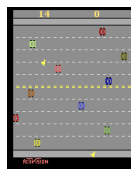

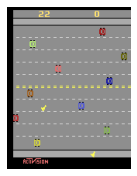

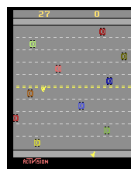

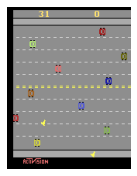

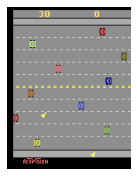

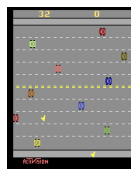

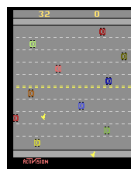

In [18]:
%%time

for i in range(NB_EPOQUES):
    game_over = False

    state = env.reset()
    state = reduce_state(state[0])[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
    score = 0
    total_reward = 0

    # onfig for gif saving
    frames = []
    FRAME_FREQ = 100
    REWARDS_FREQ = 10


    while not game_over:
        if i % FRAME_FREQ == 0:
            frames.append(env.render())

        old_state = state
        ob, reward, game_over, _, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores.append(score)
    total_rewards.append(total_reward)

    with open(f'DQL_GAMMA({GAMMA})_N0({N0}))_R(CRO_{reward_policy.REWARD_IF_CROSS}-COL_{reward_policy.REWARD_IF_COLLISION})_EP{NB_EPOQUES}.csv', "a") as file:
        file.write(f"{i},{GAMMA},{AVAILABLE_ACTIONS},{N0},{reward_policy.REWARD_IF_CROSS},{reward_policy.REWARD_IF_COLLISION},{reward_policy.REWARD_IF_STILL},{NB_EPOQUES},{agent.getEpsilon():.2f},{agent.getAlpha():.2f},{total_reward:7.2f},{sum(scores) / len(scores):.2f},{sum(scores[-10:]) / len(scores[-10:]):5.2f},{score:2}"+"\n")

    if i % FRAME_FREQ == 0:
        gif._save_frames_as_gif(frames=frames, path='./gif/', filename=f'DQL_GAMMA({GAMMA})_N0({N0}))_R(CRO_{reward_policy.REWARD_IF_CROSS}-COL_{reward_policy.REWARD_IF_COLLISION})_EP{NB_EPOQUES}_{i}.gif')
        
    print_result(i, scores, total_reward, score)

clear_output(wait=True)    

## Analyze scores and rewards

<Axes: xlabel='Episode', ylabel='Final Score'>

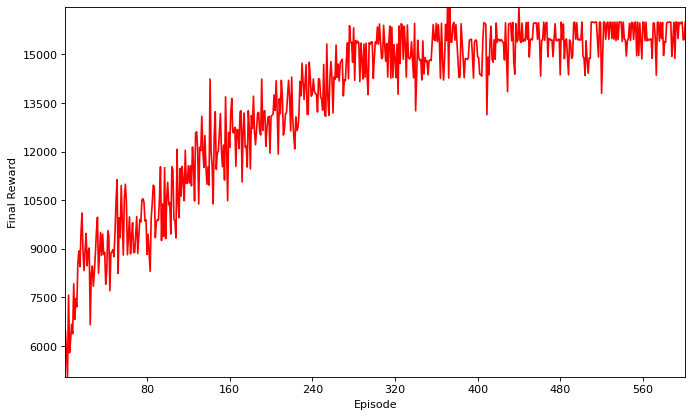

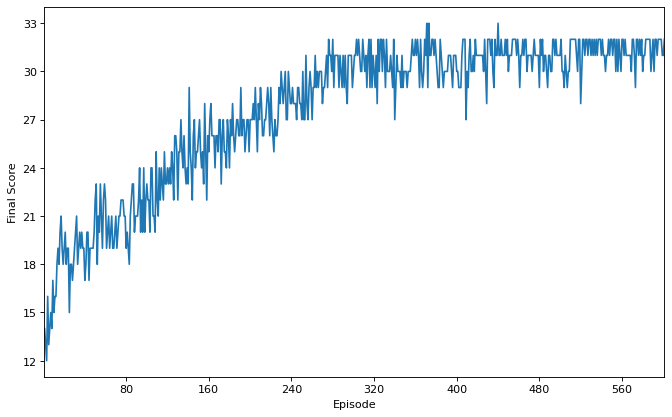

In [19]:
aux_plots.plot_rewards(total_rewards)
aux_plots.plot_scores(scores)

## Serialize the model

In [20]:
exp = serializer.Experiment(agent, scores, total_rewards, reduce_state, reward_policy)
exp.save_experiment(f'DQL_GAMMA({GAMMA})_N0({N0}))_R(CRO_{reward_policy.REWARD_IF_CROSS}-COL_{reward_policy.REWARD_IF_COLLISION})_EP{NB_EPOQUES}')